In [12]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools

In [13]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = y_train.flatten()
y_test = y_test.flatten()

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
input_shape = (32, 32, 3)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
x_test=x_test / 255.0

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

In [4]:
# Setting hyperparameters
batch_size = 32
num_classes = 10
epochs = 5

In [36]:
# Implemented DenseNet121 with the adjustable ImageNet weights and without ImageNet weights

from tensorflow.keras import layers
from tensorflow.keras.models import Model

def transition_block(x, filters):
    x = layers.BatchNormalization()(x) #1.001e-5
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(filters, 1, use_bias=False)(x)
    x = layers.AveragePooling2D(2, strides=2)(x)
    return x

def conv_block(x, blocks):
    for i in range(blocks):
        x1 = layers.BatchNormalization()(x)
        x1 = layers.Activation("relu")(x1)
        x1 = layers.Conv2D(128, 1, use_bias=False)(x1)

        x1 = layers.BatchNormalization()(x1)
        x1 = layers.Activation("relu")(x1)
        x1 = layers.Conv2D(32, 3, padding="same", use_bias=False)(x1)
        x = layers.Concatenate(axis=3)([x, x1])
    return x

input_layer = layers.Input(shape=(32, 32, 3)) 


# Widen Images Framesize to pass through all layers
x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(input_layer) # If images is bigger, this line can be deleted
x = layers.Conv2D(64, 7, strides=2, use_bias=False)(x)

x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

# Widen Images Framesize to pass through all layers
x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x) # If images is bigger, this line can be deleted
x = layers.MaxPooling2D(3, strides=2)(x)

x = conv_block(x, blocks=6)
x = transition_block(x, 128)

x = conv_block(x, blocks=12)
x = transition_block(x, 256)

x = conv_block(x, blocks=24)
x = transition_block(x, 512)
x = conv_block(x, blocks=16)

x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = Model(input_layer, outputs = x)

# Here is where the ImageNet is loaded
# This 
# x.load_weights('/kaggle/input/densenet121-weight/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5')

x = layers.GlobalAveragePooling2D()(x.output)
x = layers.Dense(10, activation = 'softmax')(x)
    
DenseNet_imp = Model(input_layer, outputs = x)
DenseNet_imp.compile(loss = 'categorical_crossentropy', 
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.003), 
                 metrics = ["accuracy"])

In [ ]:
history = DenseNet_imp.fit(x_train, y_train, 
                           batch_size=batch_size, epochs= 20) # epochs = 20 without pre-train on ImageNet Dataset

test_loss, test_acc = DenseNet_imp.evaluate(x_test, y_test)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(DenseNet_imp, to_file = 'DenseNet121_Implement.png', show_shapes = True, show_layer_names = True)

In [43]:
# Custom DenseNet121 
input_layer = layers.Input(shape=(32, 32, 3)) 

# Widen Images Framesize to pass through all layers
x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(input_layer) # If images is bigger, this line can be deleted
x = layers.Conv2D(64, 7, strides=2, use_bias=False)(x)

x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

# Widen Images Framesize to pass through all layers
x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x) # If images is bigger, this line can be deleted
x = layers.MaxPooling2D(3, strides=2)(x)

x1 = conv_block(x, blocks=6)
x2 = transition_block(x1, 128)

x3 = conv_block(x2, blocks=12)
x4 = transition_block(x3, 256)

Conv0   = layers.Conv2D(256, 2, strides=2, use_bias=False)(x2)
Fusion1 = layers.Concatenate(axis=3)([x4, Conv0])
Conv1   = layers.Conv2D(256, 1, strides=1, use_bias=False)(Fusion1)

x5 = conv_block(Conv1, blocks=24)
x6 = transition_block(x5, 512)

Conv00   = layers.Conv2D(512, 2, strides=2, use_bias=False)(x4)
Fusion2 = layers.Concatenate(axis=3)([x6, Conv00])
Conv2   = layers.Conv2D(512, 1, strides=1, use_bias=False)(Fusion2)

x7 = conv_block(Conv2, blocks=16)

x = layers.BatchNormalization()(x7)
x = layers.Activation("relu")(x)

x = Model(input_layer, outputs = x)


x = layers.GlobalAveragePooling2D()(x.output)
x = layers.Dense(10, activation = 'softmax')(x)
    
DenseNet_imp = Model(input_layer, outputs = x)
DenseNet_imp.compile(loss = 'categorical_crossentropy', 
                 optimizer = tf.keras.optimizers.SGD(learning_rate=0.003), 
                 metrics = ["accuracy"])

In [42]:
history = DenseNet_imp.fit(x_train, y_train, 
                           batch_size=batch_size, epochs= 20) # epochs = 20 without pre-train on ImageNet Dataset

test_loss, test_acc = DenseNet_imp.evaluate(x_test, y_test)

Train on 50000 samples
Epoch 1/20
50000/50000 [==============================] - 76s 2ms/sample - loss: 1.6859 - accuracy: 0.3872
Epoch 2/20
50000/50000 [==============================] - 65s 1ms/sample - loss: 1.3816 - accuracy: 0.5017
Epoch 3/20
50000/50000 [==============================] - 65s 1ms/sample - loss: 1.2338 - accuracy: 0.5594
Epoch 4/20
50000/50000 [==============================] - 65s 1ms/sample - loss: 1.1138 - accuracy: 0.6060
Epoch 5/20
50000/50000 [==============================] - 65s 1ms/sample - loss: 1.0187 - accuracy: 0.6382
Epoch 6/20
50000/50000 [==============================] - 65s 1ms/sample - loss: 0.9312 - accuracy: 0.6706
Epoch 7/20
50000/50000 [==============================] - 65s 1ms/sample - loss: 0.8558 - accuracy: 0.6994
Epoch 8/20
50000/50000 [==============================] - 65s 1ms/sample - loss: 0.7816 - accuracy: 0.7260
Epoch 9/20
50000/50000 [==============================] - 65s 1ms/sample - loss: 0.7166 - accuracy: 0.7485
Epoch 10/20
50

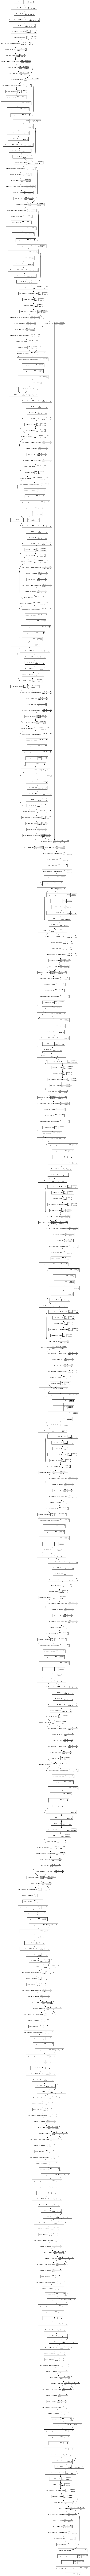

In [46]:
# Custom DenseNet121 with additional layers
from tensorflow.keras.utils import plot_model
plot_model(DenseNet_imp, to_file = 'DenseNet121_Implement.png', show_shapes = True, show_layer_names = True)